# Estudio del subárbol Phenotypic abnormality en HPO

## 1. Profundidad
Resumen:  
Tamaño: 90978 fenotipos, Profundidad máxima: 14, Media: 5.97.
Plot de dispersión abajo.  
csv en [./results](./results)

In [29]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
config_path = os.path.join(os.path.dirname(notebook_path), "project_config")
sys.path.append(config_path)

import project_config
from project_config import *

print(f"SEED={SEED}")

SEED=42


In [30]:
# Pasos:
# 1. Cargar la ontología HPO
# 2. Obtener subárbol Phenotypic abnormality
# 3. Obtener tamaño N
# 4. Obtener conteo de las profundidades de los nodos del subárbol
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol
# 6. Plot de dispersión de la profundidad media vs. T
import numpy as np
import pandas as pd
from pyhpo import Ontology

PATH_ONTO = "../pubmed-queries/hpo-22-12-15-data"

onto = Ontology(PATH_ONTO)
rDir = 'results-omim'

# 2. Phenotypic abnormality childs
pha = onto.get_hpo_object('HP:0000118')

# 3 & 4

N = 0
h = 0
MAXDEPTH = 14

# Array de profundidades: de 0 a MAX_DEPTH

from queue import Queue

contProfundidades = np.array([0]*(MAXDEPTH+1))
contHojas = np.array([0]*(MAXDEPTH+1))
sAux = Queue()
sAux.put([pha,0])
visitados = {}
phenAttributes = ['id', 'name', 'depth', 'isLeaf']
phenValues = []
while not sAux.empty():
    nodo = sAux.get()
    p = nodo[0]
    if p in visitados.keys():
        visitados[p] = visitados[p] + 1
        continue
    d = nodo[1]
    N = N + 1
    contProfundidades[d] = contProfundidades[d] + 1
    if d > h:
        h = d
    isLeaf = True
    if p.children:
        for c in p.children:
            sAux.put([c,d+1])
        isLeaf = False 
    else:
        contHojas[d] = contHojas[d] + 1
    visitados[p] = 1
    phenValues.append([p.id, p.name, d, isLeaf])

# Save map as pd

df = pd.DataFrame.from_dict(visitados, orient='index')
df.to_csv(rDir + '/visitados.csv')

print("N = ", N)
print("Max depth = ", h)
dfPhen = pd.DataFrame(phenValues, columns=phenAttributes, index=None)
dfPhen.to_csv(rDir + '/phenotypic_abnormality.csv')

N =  16537
Max depth =  14


Depths: [   1   23  155  800 2157 3789 3696 2886 1870  678  334  106   27   13
    2]
[    0     1    24   179   979  3136  6925 10621 13507 15377 16055 16389
 16495 16522 16535 16537]
Leafs: [   0    0   28  318 1198 2502 2569 1985 1535  543  277   95   20   12
    2]
[    0     0     0    28   346  1544  4046  6615  8600 10135 10678 10955
 11050 11070 11082 11084]


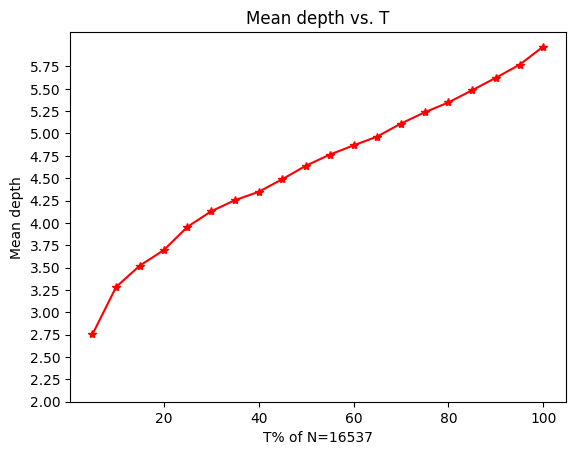

In [31]:
# 5. Para cada T = 10%N, 20%N, ..., 100%N:
# a. Obtener la profundidad media de los T primeros nodos del subárbol

# Array sumas acumuladas de contProfundidades

accumDepth = np.array([0]*(MAXDEPTH+2))
accumHojas = np.array([0]*(MAXDEPTH+2))
for i in range(1,MAXDEPTH+2):
    accumDepth[i] = accumDepth[i-1] + contProfundidades[i-1]
    accumHojas[i] = accumHojas[i-1] + contHojas[i-1]

print("Depths:", contProfundidades)
print(accumDepth)

print("Leafs:", contHojas)
print(accumHojas)

step = 5
nsteps = 100//step
meanDepth = [0] * nsteps

for j in range(0, nsteps):
    sum = 0
    T = (j+1)*step/100
    acum = 0
    i = 0
    k = 0
    while acum < T*N:
        if acum + contProfundidades[i] > T*N:
            k = T*N - acum
            sum = sum + k*i
            acum = T*N
        else:
            sum = sum + contProfundidades[i]*i
            acum = acum + contProfundidades[i]
        i = i + 1
        
    #print("T = ", T, " profundidad media total = ", sum/(T*N))
    meanDepth[j] = sum/(T*N)

# 6. Plot de dispersión de la profundidad media vs. T

import matplotlib.pyplot as plt
import numpy as np

T = np.arange(step,100+step,step)
plt.plot(T, meanDepth, 'r')
plt.plot(T, meanDepth, 'r*')
plt.xlabel(f'T% of N={N}')
plt.ylabel('Mean depth')
plt.yticks(np.arange(int(meanDepth[0]), int(meanDepth[-1])+1, 0.25))
plt.title('Mean depth vs. T')
plt.show()

# Save mean depth
df = pd.DataFrame({'T': T, 'Mean depth': meanDepth})
df.to_csv(rDir + '/mean_depth.csv', index=False)


## 2. Selección de nodos
Vamos a contar cuántos nodos son escogidos a cada profundidad. Se escogen los nodos hoja del árbol cortado a profundidad $d$.

Para cada profundidad $d$ se toman todos los nodos hoja del subárbol que tiene todos los nodos de profundidad $\le d.$ Esto "cubre" intuitivamente el 100% de la ontología. Todo nodo a profundidad mayor que $d$ tiene un único ascendiente en el conjunto de nodos escogidos.

[1, 23, 155, 828, 2503, 5333, 7742, 9501, 10470, 10813, 11012, 11061, 11077, 11083, 11084]


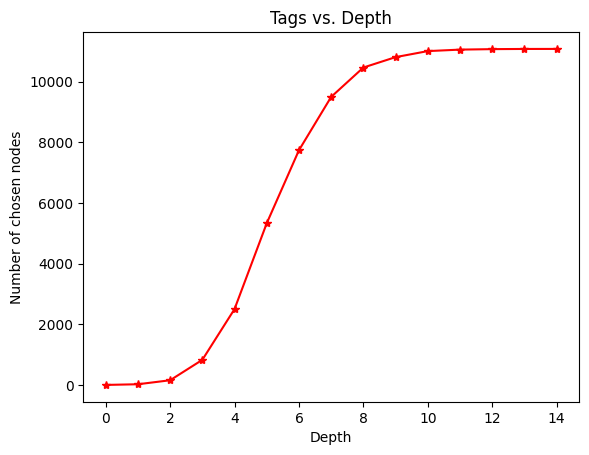

In [32]:
# 7. Plot Nº nodos escogidos vs Profundidad d

# chosen nodes = nodos hoja del subárbol con profundidad d
y = [0]*(MAXDEPTH+1)
z = [0]*(MAXDEPTH+1)
for i in range(MAXDEPTH+1):
    y[i] = contProfundidades[i] + accumHojas[i]

print(y)

plt.plot(range(MAXDEPTH+1), y, 'r')
plt.plot(range(MAXDEPTH+1), y, 'r*')

plt.xlabel('Depth')
plt.ylabel('Number of chosen nodes')
plt.title('Tags vs. Depth')
plt.show()


* Tabla chosen nodes vs depth: subtreePercent es el porcentaje de nodos a profundidad <= d

In [33]:
# Save depth count
dfDepth = pd.DataFrame({'depth': range(MAXDEPTH+1), 'count': contProfundidades, 'leafs': contHojas, 'subtree':accumDepth[1:],'chosen': y})
dfDepth['out'] = N - dfDepth['subtree']
dfDepth['subtreePercent'] = dfDepth['subtree']/N * 100
dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')
display(dfDepth)

,depth,count,leafs,subtree,chosen,out,subtreePercent
0,0,1,0,1,1,16536,0.006047
1,1,23,0,24,23,16513,0.145129
2,2,155,28,179,155,16358,1.082421
3,3,800,318,979,828,15558,5.920058
4,4,2157,1198,3136,2503,13401,18.963536
5,5,3789,2502,6925,5333,9612,41.875794
6,6,3696,2569,10621,7742,5916,64.225676
7,7,2886,1985,13507,9501,3030,81.677451
8,8,1870,1535,15377,10470,1160,92.985427
9,9,678,543,16055,10813,482,97.085324


Si quisiéramos no coger todos los nodos del corte a profundidad $d$ sino una muestra no estaríamos cubriendo el 100% de la ontología. ¿Cuánto estaríamos cubriendo? Pues depende de cómo midas el "tamaño" de cada nodo en la ontología. ¿Tienen todos los nodos el mismo tamaño? Entonces solo importaría el número de descendientes de los nodos que se dejan fuera de la muestra. Creo que convendría más medirlo por el IC, pero es complicar la cosa. ¿Cómo se calcula el IC de un conjunto de nodos? Si lo supiera pondría:
$$ \%cubierto = \frac{IC(muestra)} {IC(elegidos)} $$
Una alternativa sería considerando que los nodos más importantes son los que más nodos tienen por debajo:
$$ \%cubierto = \frac{Tam(muestra)} {Tam(elegidos)}$$
donde $Tam(N)$ se refiere al tamaño del subárbol del nodo $N$.

Text(0, 0.5, '% Cubierto')

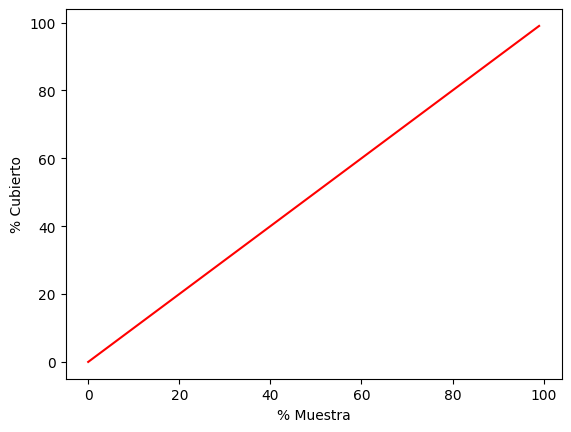

In [34]:
plt.plot(range(100),range(100),'r')
plt.xlabel('% Muestra')
plt.ylabel('% Cubierto')

## Estudiando el IC
IC es una medida de la información del fenotipo y la vamos a utilizar para determinar a priori qué profundidad es la mejor candidata para realizar la muestra. Nos quedaremos con la mayor profundidad $d$ que reporte un IC medio razonable de las etiquetas elegidas por el método anterior (cortar el "árbol" hasta $d$).

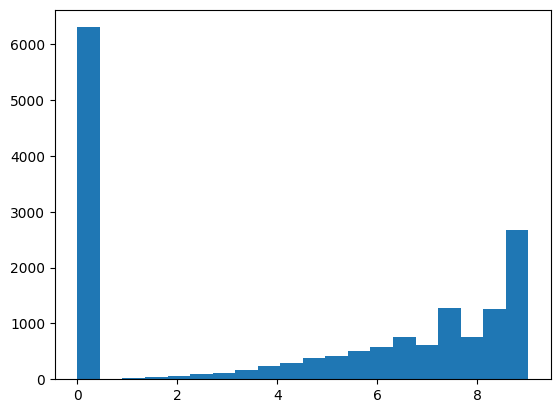

In [35]:
def get_ic(x):
    p = onto.get_hpo_object(x)
    ic = p.information_content.omim
    return ic

dfPhen['ic'] = dfPhen['id'].apply(lambda x: get_ic(x))
plt.hist(dfPhen['ic'], bins=20)
dfPhen.to_csv(rDir + '/phenotypic_abnormality.csv', index=False)

In [36]:
def get_dist(dfPhen, depth):
    dMean = dfPhen[dfPhen['depth'] == depth]['ic'].mean()
    dVar = dfPhen[dfPhen['depth'] == depth]['ic'].var()
    count = int(dfPhen[dfPhen['depth'] == depth]['ic'].count())
    print(f"Depth {depth}: n={count}, mu={dMean}, s^2={dVar}")
    plt.hist(dfPhen[dfPhen['depth'] == depth]['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC histogram for depth={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}.png")
    plt.clf()
    return dMean, dVar

def get_dist_zeros(dfPhen, depth):
    count = dfPhen[dfPhen['depth'] == depth]['ic'].count()
    dfZeros = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] == 0.0)]
    dfNotZeros = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] != 0.0)]
    zeros = int(dfZeros['ic'].count())
    count = int(count - zeros)
    meanAlt = dfNotZeros['ic'].mean()
    varAlt = dfNotZeros['ic'].var()
    trueCount = dfPhen[(dfPhen['depth'] == depth) & (dfPhen['ic'] > 0.0)]['ic'].count()
    trueCount += dfPhen[(dfPhen['depth'] < depth) & (dfPhen['ic'] > 0.0) & (dfPhen['isLeaf'] == True)]['ic'].count()
    print(f"Depth {depth}: trueCount={trueCount},notzeros={count}, zeros={zeros}, mu={meanAlt}, s^2={varAlt}")
    plt.hist(dfNotZeros['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC>0 histogram for depth={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}_not_zeros.png")
    plt.clf()
    return int(trueCount), int(zeros), int(count), meanAlt, varAlt

dfDist = dfDepth['depth'].apply(lambda x: get_dist(dfPhen, x)).apply(pd.Series)
dfDist.columns = ['mean', 'var']
dfDepth = pd.concat([dfDepth, dfDist], axis=1)
dfDistZeros = dfDepth['depth'].apply(lambda x: get_dist_zeros(dfPhen, x)).apply(pd.Series)
dfDistZeros.columns = ['trueCount', 'zeros', 'notZeros', 'meanGTZ', 'varGTZ']
dfDepth = pd.concat([dfDepth, dfDistZeros], axis=1)
dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')


Depth 0: n=1, mu=0.00036046861309514645, s^2=nan
Depth 1: n=23, mu=1.946496335667164, s^2=1.926964135014481
Depth 2: n=155, mu=4.277980203693624, s^2=7.601742421876808
Depth 3: n=800, mu=4.854322074002118, s^2=10.465716043920105
Depth 4: n=2157, mu=4.67302033323746, s^2=11.746655329278788
Depth 5: n=3789, mu=4.780325419950128, s^2=12.93517491468172
Depth 6: n=3696, mu=4.803738018417919, s^2=14.0584865372476
Depth 7: n=2886, mu=4.398161334350028, s^2=15.51935038361826
Depth 8: n=1870, mu=3.1395270991279687, s^2=15.00670589176702
Depth 9: n=678, mu=3.830560789609985, s^2=15.806303038433171
Depth 10: n=334, mu=3.4536106107083304, s^2=15.30431985676758
Depth 11: n=106, mu=2.6570305238105325, s^2=14.711802363232735
Depth 12: n=27, mu=2.097463294682839, s^2=13.222746746759437
Depth 13: n=13, mu=0.0, s^2=0.0
Depth 14: n=2, mu=0.0, s^2=0.0
Depth 0: trueCount=1,notzeros=1, zeros=0, mu=0.00036046861309514645, s^2=nan
Depth 1: trueCount=23,notzeros=23, zeros=0, mu=1.946496335667164, s^2=1.9269641

<Figure size 640x480 with 0 Axes>

In [37]:
df = dfDepth[(dfDepth['depth'] >= 5)].copy()
df.drop(['subtree', 'leafs', 'chosen', 'out', 'subtreePercent', 'mean', 'var'], axis=1, inplace=True)
display(df)

,depth,count,trueCount,zeros,notZeros,meanGTZ,varGTZ
5,5,3789,3441.0,1228.0,2561.0,7.072492,2.922351
6,6,3696,4721.0,1296.0,2400.0,7.397757,2.455317
7,7,2886,5486.0,1226.0,1660.0,7.646442,2.135380
8,8,1870,5713.0,1100.0,770.0,7.624566,2.231794
9,9,678,5844.0,339.0,339.0,7.661122,2.226155
10,10,334,5894.0,181.0,153.0,7.539255,2.523184
11,11,106,5896.0,71.0,35.0,8.047007,0.784651
12,12,27,5897.0,20.0,7.0,8.090216,0.735469
13,13,13,5893.0,13.0,0.0,NaN,NaN
14,14,2,5893.0,2.0,0.0,NaN,NaN


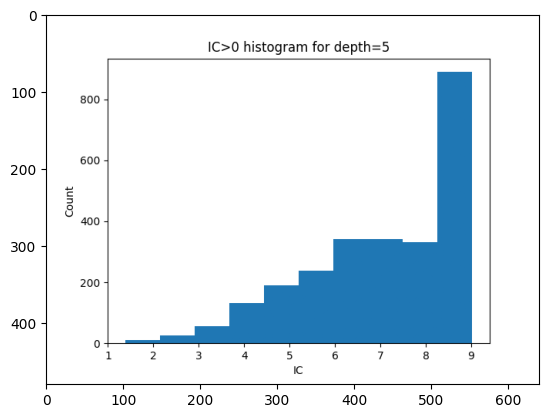

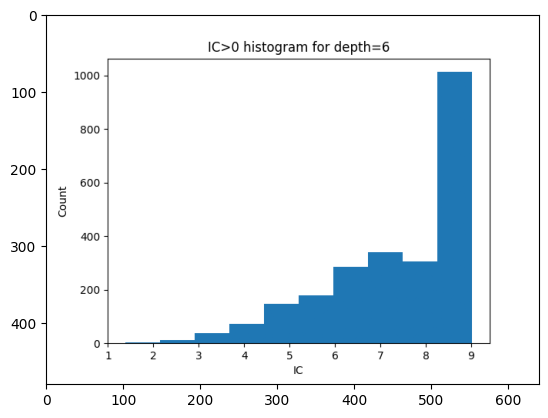

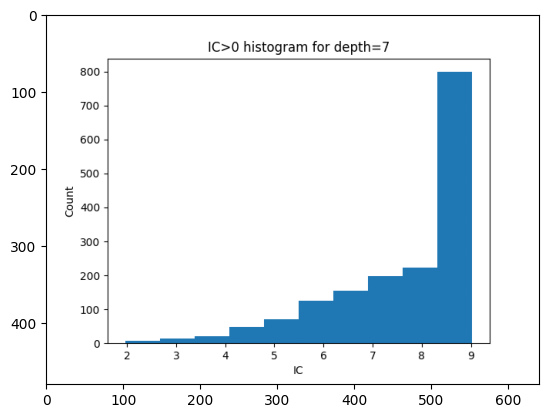

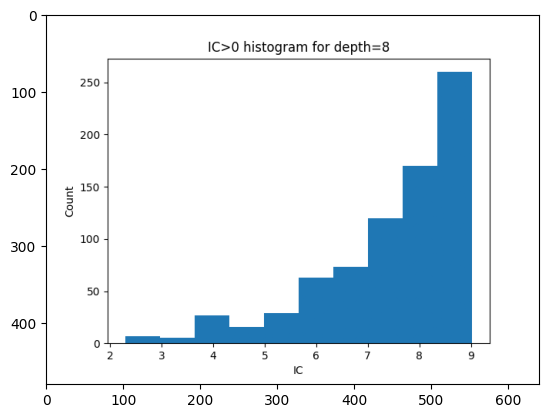

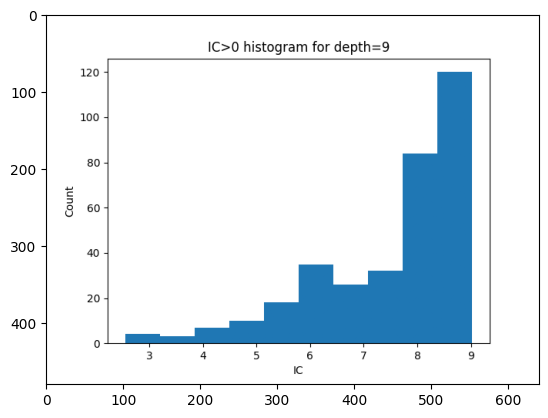

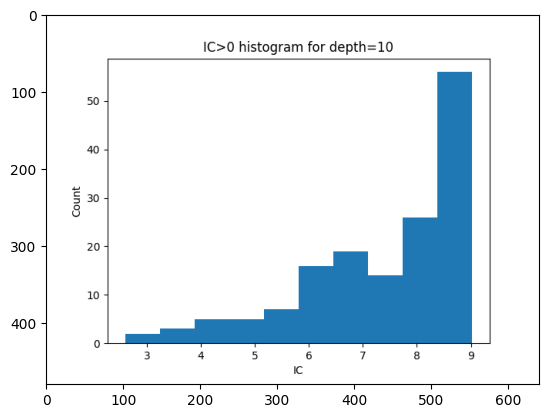

In [38]:
import matplotlib.image as mpimg
for d in range(5,11):
    img = mpimg.imread(f"{rDir}/images/ic_depth_{d}_not_zeros.png")
    plt.imshow(img)
    plt.show()

In [39]:
# Conseguir distribucion real a cada profundidad
def get_true_dist(dfPhen, depth):
    df = dfPhen[dfPhen['ic'] > 0]
    dfLess = df[(df['depth'] < depth) & df['isLeaf']]
    dfEq = df[df['depth'] == depth]
    dfTrue = pd.concat([dfLess, dfEq])
    mean = dfTrue['ic'].mean()
    var = dfTrue['ic'].var()
    count = dfTrue['ic'].count()
    print(f"Depth {depth}: n={count}, mu={mean}, s^2={var}")
    plt.hist(dfTrue['ic'])
    plt.xlabel('IC')
    plt.ylabel('Count')
    plt.title(f'IC>0 histogram for true depth selection={depth}')
    plt.savefig(f"{rDir}/images/ic_depth_{depth}_true.png")
    plt.clf()
    return mean, var

dfTrueDist = dfDepth['depth'].apply(lambda x: get_true_dist(dfPhen, x)).apply(pd.Series)
dfTrueDist.columns = ['trueMean', 'trueVar']
dfDepth = pd.concat([dfDepth, dfTrueDist], axis=1)

dfDepth.to_csv(rDir + '/depth_count.csv', index=False, sep='\t')

Depth 0: n=1, mu=0.00036046861309514645, s^2=nan
Depth 1: n=23, mu=1.946496335667164, s^2=1.926964135014481
Depth 2: n=139, mu=4.770409579658358, s^2=6.116991659742075
Depth 3: n=639, mu=6.285696383589417, s^2=4.754416825141791
Depth 4: n=1725, mu=6.78834312318448, s^2=3.6652281261020523
Depth 5: n=3441, mu=7.28757591829278, s^2=2.6766943752887586
Depth 6: n=4721, mu=7.625331658490143, s^2=2.041079437935734
Depth 7: n=5486, mu=7.829782741531307, s^2=1.6625659745119887
Depth 8: n=5713, mu=7.9013192437096205, s^2=1.5215121939181024
Depth 9: n=5844, mu=7.934331544409973, s^2=1.4446144091627244
Depth 10: n=5894, mu=7.94664356276839, s^2=1.4252672348906712
Depth 11: n=5896, mu=7.952516642309717, s^2=1.412389888811457
Depth 12: n=5897, mu=7.953459312098321, s^2=1.41184539542463
Depth 13: n=5893, mu=7.95349046453559, s^2=1.4122694313660356
Depth 14: n=5893, mu=7.95349046453559, s^2=1.4122694313660356


<Figure size 640x480 with 0 Axes>

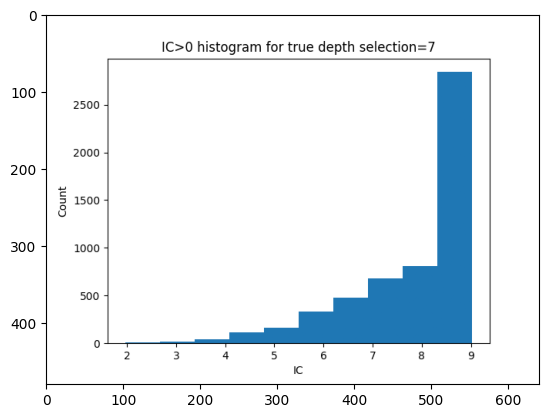

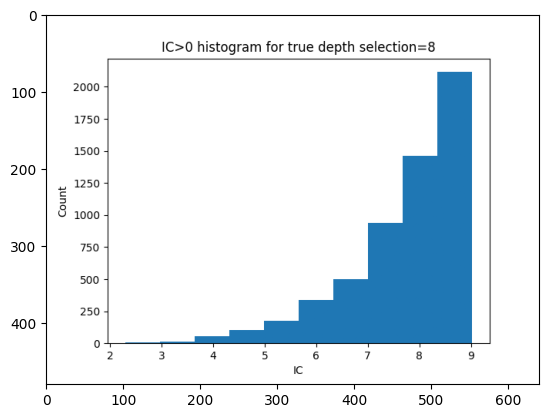

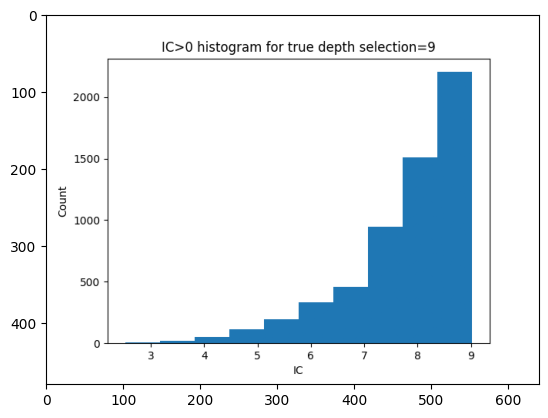

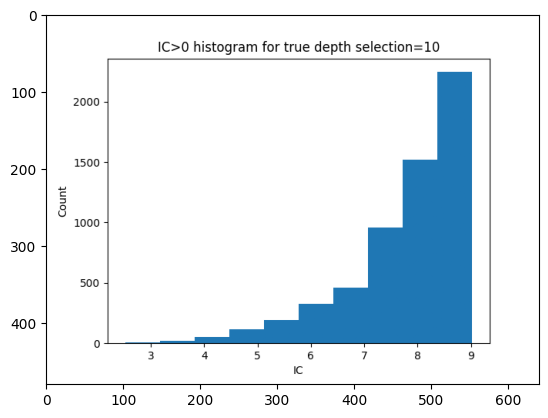

In [40]:
import matplotlib.image as mpimg
for d in range(7,11):
    img = mpimg.imread(f"{rDir}/images/ic_depth_{d}_true.png")
    plt.imshow(img)
    plt.show()

## TODO:
1. Calcular % ontología cubierta por depth=10
2. Hacer un informe sobre el análisis que hemos hecho para la selección de fenotipos:
   1. Método de selección
   2. Por qué usamos el IC
   3. NAs
   4. Resultados
   5. % ontología cubierto por la selección

In [41]:
display(dfDepth)

,depth,count,leafs,subtree,chosen,out,subtreePercent,mean,var,trueCount,zeros,notZeros,meanGTZ,varGTZ,trueMean,trueVar
0,0,1,0,1,1,16536,0.006047,0.000360,NaN,1.0,0.0,1.0,0.000360,NaN,0.000360,NaN
1,1,23,0,24,23,16513,0.145129,1.946496,1.926964,23.0,0.0,23.0,1.946496,1.926964,1.946496,1.926964
2,2,155,28,179,155,16358,1.082421,4.277980,7.601742,139.0,16.0,139.0,4.770410,6.116992,4.770410,6.116992
3,3,800,318,979,828,15558,5.920058,4.854322,10.465716,639.0,178.0,622.0,6.243501,4.778244,6.285696,4.754417
4,4,2157,1198,3136,2503,13401,18.963536,4.673020,11.746655,1725.0,635.0,1522.0,6.622671,3.730367,6.788343,3.665228
5,5,3789,2502,6925,5333,9612,41.875794,4.780325,12.935175,3441.0,1228.0,2561.0,7.072492,2.922351,7.287576,2.676694
6,6,3696,2569,10621,7742,5916,64.225676,4.803738,14.058487,4721.0,1296.0,2400.0,7.397757,2.455317,7.625332,2.041079
7,7,2886,1985,13507,9501,3030,81.677451,4.398161,15.519350,5486.0,1226.0,1660.0,7.646442,2.135380,7.829783,1.662566
8,8,1870,1535,15377,10470,1160,92.985427,3.139527,15.006706,5713.0,1100.0,770.0,7.624566,2.231794,7.901319,1.521512
9,9,678,543,16055,10813,482,97.085324,3.830561,15.806303,5844.0,339.0,339.0,7.661122,2.226155,7.934332,1.444614


In [42]:
# ntrue es trueCount a profundidad MAXDEPTH
ntrue = dfDepth[dfDepth['depth'] == MAXDEPTH]['trueCount'].values[0]
def onto_percent(onto, dfDepth, d, ntrue, tam=0):
    # 1. Eliminar nodos nulos (IC = 0)
    # 2. Seleccionar todos los nodos hoja con profundidad < d
    # 3. Añadir todos los nodos con profundidad = d
    # 4. Calcular número de nodos hoja no nulos cubiertos en la ontología
        # mediante un recorrido en anchura o profundidad
    # 5. Calcular el porcentaje de nodos hoja no nulos cubiertos
    # 6. Return n, porcentaje y dataframe de la seleccion

    # 1.
    df = dfPhen[dfPhen['ic'] > 0]
    # 2.
    dfLess = df[(df['depth'] < d) & df['isLeaf']]
    
    # 3.
    dfEq = df[df['depth'] == d]
    
    dfTrue = pd.concat([dfLess, dfEq])

    m = dfTrue['ic'].count() 
    if tam > 0:
        dfTrue = dfTrue.sample(min(tam,m), random_state=SEED)
    # 4.
    cont = 0
    sAux = Queue()
    for id in dfTrue['id']:
        sAux.put(onto.get_hpo_object(id))
    visitados = set()
    while not sAux.empty():
        p = sAux.get()
        if p in visitados:
            continue
        if p.children:
            for c in p.children:
                sAux.put(c)
        else:
            if p.information_content.omim > 0.0:
                cont += 1
        visitados.add(p)
    # 5.
    return cont, dfTrue

fullCover = {}
for d in range(MAXDEPTH+1):
    n, df = onto_percent(onto, dfDepth, d, ntrue)
    fullCover[d] = n
    print(f"Depth {d}: {n} not-null nodes covered, {n/ntrue*100}%")

dfDepth['fullCover'] = dfDepth['depth'].apply(lambda x: fullCover[x])

Depth 0: 5893 not-null nodes covered, 100.0%
Depth 1: 5893 not-null nodes covered, 100.0%
Depth 2: 5893 not-null nodes covered, 100.0%
Depth 3: 5893 not-null nodes covered, 100.0%
Depth 4: 5893 not-null nodes covered, 100.0%
Depth 5: 5893 not-null nodes covered, 100.0%
Depth 6: 5893 not-null nodes covered, 100.0%
Depth 7: 5893 not-null nodes covered, 100.0%
Depth 8: 5893 not-null nodes covered, 100.0%
Depth 9: 5893 not-null nodes covered, 100.0%
Depth 10: 5893 not-null nodes covered, 100.0%
Depth 11: 5893 not-null nodes covered, 100.0%
Depth 12: 5893 not-null nodes covered, 100.0%
Depth 13: 5893 not-null nodes covered, 100.0%
Depth 14: 5893 not-null nodes covered, 100.0%


In [43]:
trueCover = {}
TAM = 2000

for d in range(MAXDEPTH+1):
    n, df = onto_percent(onto, dfDepth, d, ntrue, tam=TAM)
    trueCover[d] = n
    print(f"Depth {d}, tam={TAM}: {n} nodes covered, {n/ntrue*100}%")

dfDepth['sample'] = dfDepth['trueCount'].apply(lambda x: int(min(x,TAM)))
dfDepth['sampleCover'] = dfDepth['depth'].apply(lambda x: trueCover[x])
dfDepth['sampleCoverPercent'] = dfDepth['sampleCover']/ntrue*100

display(dfDepth)


Depth 0, tam=2000: 5893 nodes covered, 100.0%
Depth 1, tam=2000: 5893 nodes covered, 100.0%
Depth 2, tam=2000: 5893 nodes covered, 100.0%
Depth 3, tam=2000: 5893 nodes covered, 100.0%
Depth 4, tam=2000: 5893 nodes covered, 100.0%
Depth 5, tam=2000: 4037 nodes covered, 68.50500593924995%
Depth 6, tam=2000: 2677 nodes covered, 45.426777532665874%
Depth 7, tam=2000: 2187 nodes covered, 37.11182759205837%
Depth 8, tam=2000: 2114 nodes covered, 35.873069743763786%
Depth 9, tam=2000: 2034 nodes covered, 34.51552689631767%
Depth 10, tam=2000: 2000 nodes covered, 33.93857118615306%
Depth 11, tam=2000: 2000 nodes covered, 33.93857118615306%
Depth 12, tam=2000: 2000 nodes covered, 33.93857118615306%
Depth 13, tam=2000: 2000 nodes covered, 33.93857118615306%
Depth 14, tam=2000: 2000 nodes covered, 33.93857118615306%


,depth,count,leafs,subtree,chosen,out,subtreePercent,mean,var,trueCount,zeros,notZeros,meanGTZ,varGTZ,trueMean,trueVar,fullCover,sample,sampleCover,sampleCoverPercent
0,0,1,0,1,1,16536,0.006047,0.000360,NaN,1.0,0.0,1.0,0.000360,NaN,0.000360,NaN,5893,1,5893,100.000000
1,1,23,0,24,23,16513,0.145129,1.946496,1.926964,23.0,0.0,23.0,1.946496,1.926964,1.946496,1.926964,5893,23,5893,100.000000
2,2,155,28,179,155,16358,1.082421,4.277980,7.601742,139.0,16.0,139.0,4.770410,6.116992,4.770410,6.116992,5893,139,5893,100.000000
3,3,800,318,979,828,15558,5.920058,4.854322,10.465716,639.0,178.0,622.0,6.243501,4.778244,6.285696,4.754417,5893,639,5893,100.000000
4,4,2157,1198,3136,2503,13401,18.963536,4.673020,11.746655,1725.0,635.0,1522.0,6.622671,3.730367,6.788343,3.665228,5893,1725,5893,100.000000
5,5,3789,2502,6925,5333,9612,41.875794,4.780325,12.935175,3441.0,1228.0,2561.0,7.072492,2.922351,7.287576,2.676694,5893,2000,4037,68.505006
6,6,3696,2569,10621,7742,5916,64.225676,4.803738,14.058487,4721.0,1296.0,2400.0,7.397757,2.455317,7.625332,2.041079,5893,2000,2677,45.426778
7,7,2886,1985,13507,9501,3030,81.677451,4.398161,15.519350,5486.0,1226.0,1660.0,7.646442,2.135380,7.829783,1.662566,5893,2000,2187,37.111828
8,8,1870,1535,15377,10470,1160,92.985427,3.139527,15.006706,5713.0,1100.0,770.0,7.624566,2.231794,7.901319,1.521512,5893,2000,2114,35.873070
9,9,678,543,16055,10813,482,97.085324,3.830561,15.806303,5844.0,339.0,339.0,7.661122,2.226155,7.934332,1.444614,5893,2000,2034,34.515527


Decisión: tomar la selección (sin nulos) a profundidad **10** porque:
* El IC medio de la selección crece con la profundidad, pero se estanca a esa profundidad 10 en las centésimas, aparte de que a partir de esa profundidad se añaden muy pocos nodos no nulos.
* Con una muestra de tamaño 2000 de la selección a profundidad 10 cubrimos un 32.82% de los nodos hoja no nulos de la ontología, que es un porcentaje suficiente.
* Importante considerar que si hacemos la muestra completa de 6106 nodos no nulos cubrimos el 100%.

In [44]:
columns = ['depth', 'trueMean', 'sampleCoverPercent', 'sample']
display(dfDepth[columns])
dfDepth.to_csv(rDir+'/depth_count.csv', sep='\t', index=False)


,depth,trueMean,sampleCoverPercent,sample
0,0,0.000360,100.000000,1
1,1,1.946496,100.000000,23
2,2,4.770410,100.000000,139
3,3,6.285696,100.000000,639
4,4,6.788343,100.000000,1725
5,5,7.287576,68.505006,2000
6,6,7.625332,45.426778,2000
7,7,7.829783,37.111828,2000
8,8,7.901319,35.873070,2000
9,9,7.934332,34.515527,2000


Text(0, 0.5, '%')

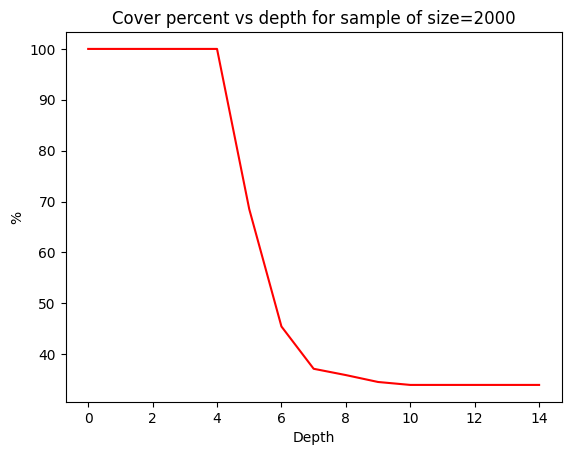

In [45]:
# Plot del sampleCoverPercent vs. depth
plt.plot(dfDepth['depth'], dfDepth['sampleCoverPercent'], 'r')
plt.title('Cover percent vs depth for sample of size=2000')
plt.xlabel('Depth')
plt.ylabel('%')